In [1]:
import os
import sys
import subprocess
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import cm
from skimage import exposure

Enter the path to your T1-weighted MRI file: /content/Brats17_TCIA_648_1_t1.nii

Initializing brain segmentation...

Segmentation completed successfully
Files in segmentation directory:
/content/fastsurfer_seg/BrainSeg/mri/mask.mgz
/content/fastsurfer_seg/BrainSeg/mri/aseg.auto_noCCseg.mgz
/content/fastsurfer_seg/BrainSeg/mri/aparc.DKTatlas+aseg.deep.mgz
/content/fastsurfer_seg/BrainSeg/mri/orig.mgz
/content/fastsurfer_seg/BrainSeg/mri/orig/001.mgz
/content/fastsurfer_seg/BrainSeg/scripts/build.log
/content/fastsurfer_seg/BrainSeg/scripts/deep-seg.log
Original shape: (240, 240, 155)
Segmentation shape: (256, 256, 256)
Segmentation verified successfully using file: /content/fastsurfer_seg/BrainSeg/mri/aparc.DKTatlas+aseg.deep.mgz

Generating axial view visualization...
Unique region IDs in this slice: [   0    2    4   10   11   12   13   14   16   17   18   24   28   41
   43   44   49   50   51   52   53   54   60   77 1002 1003 1006 1007
 1009 1015 1018 1022 1024 1028 1030 1035 2002 

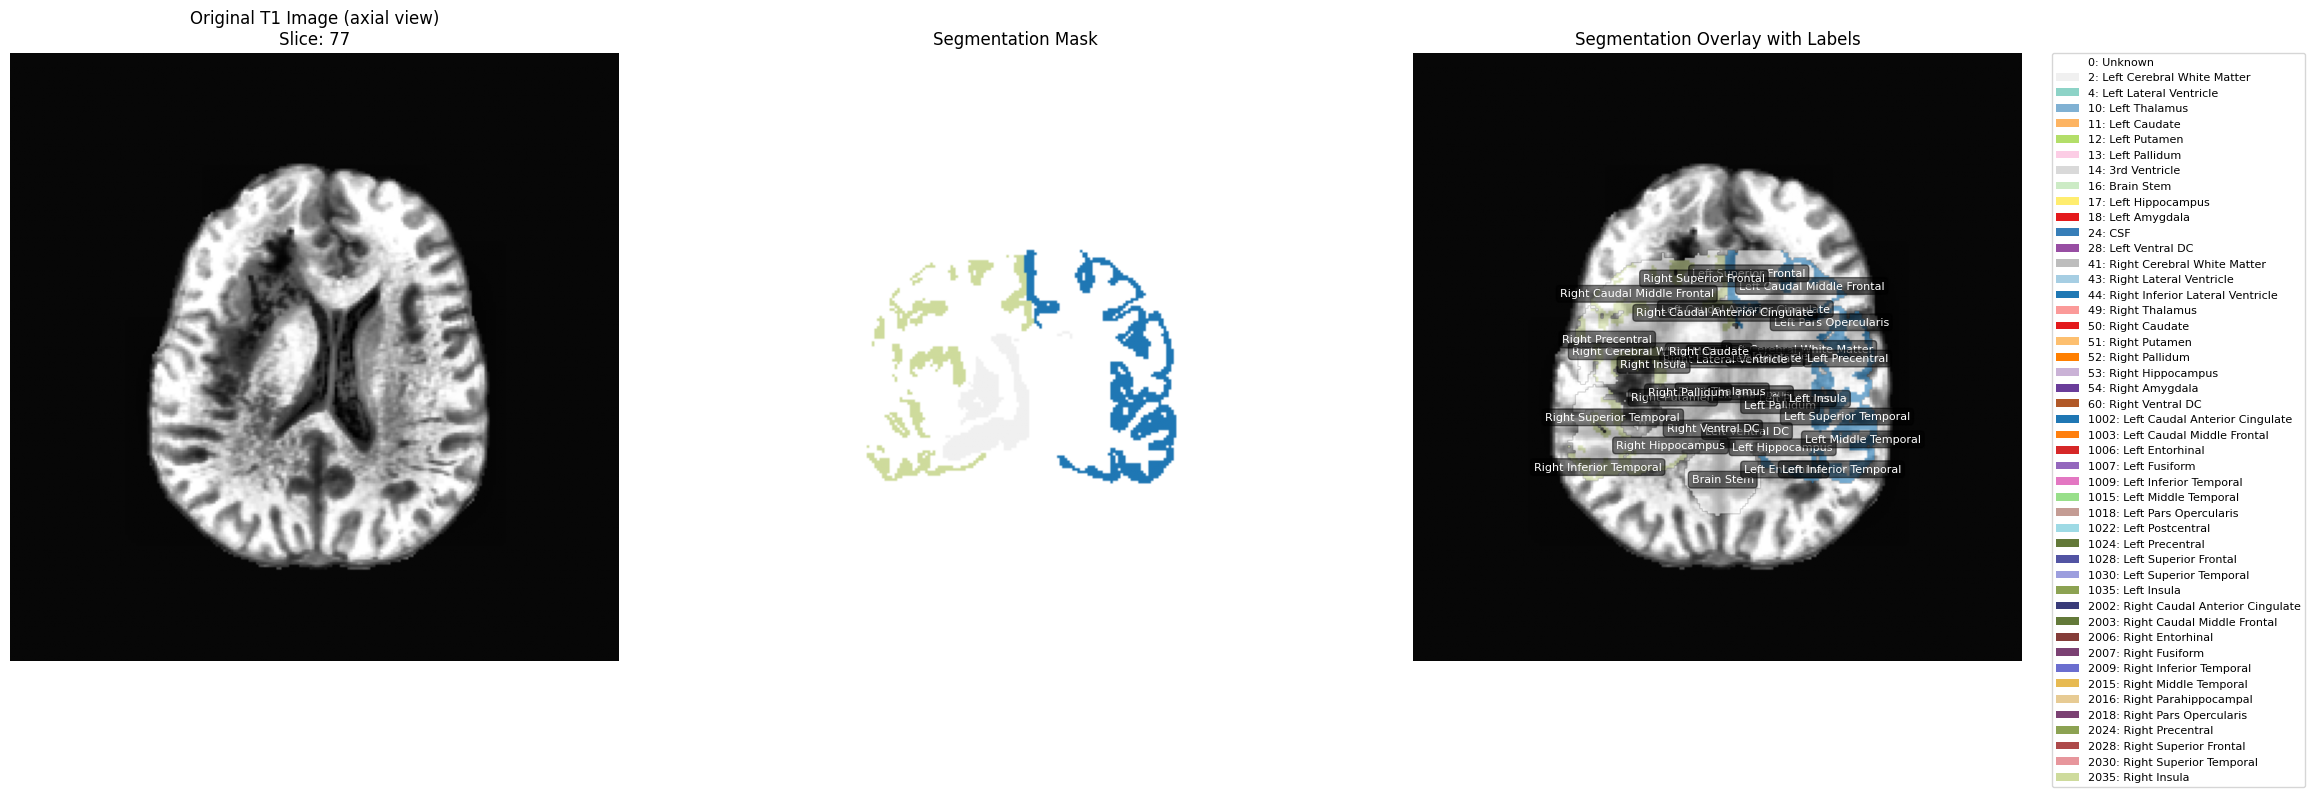


Generating coronal view visualization...
Unique region IDs in this slice: [   0    2    4   11   41   43   50   51   77 1008 1010 1012 1014 1018
 1020 1022 1023 1024 1025 1026 1027 1028 1029 1031 1035 2008 2010 2012
 2014 2018 2019 2020 2022 2023 2024 2025 2026 2027 2028 2029 2031 2035]


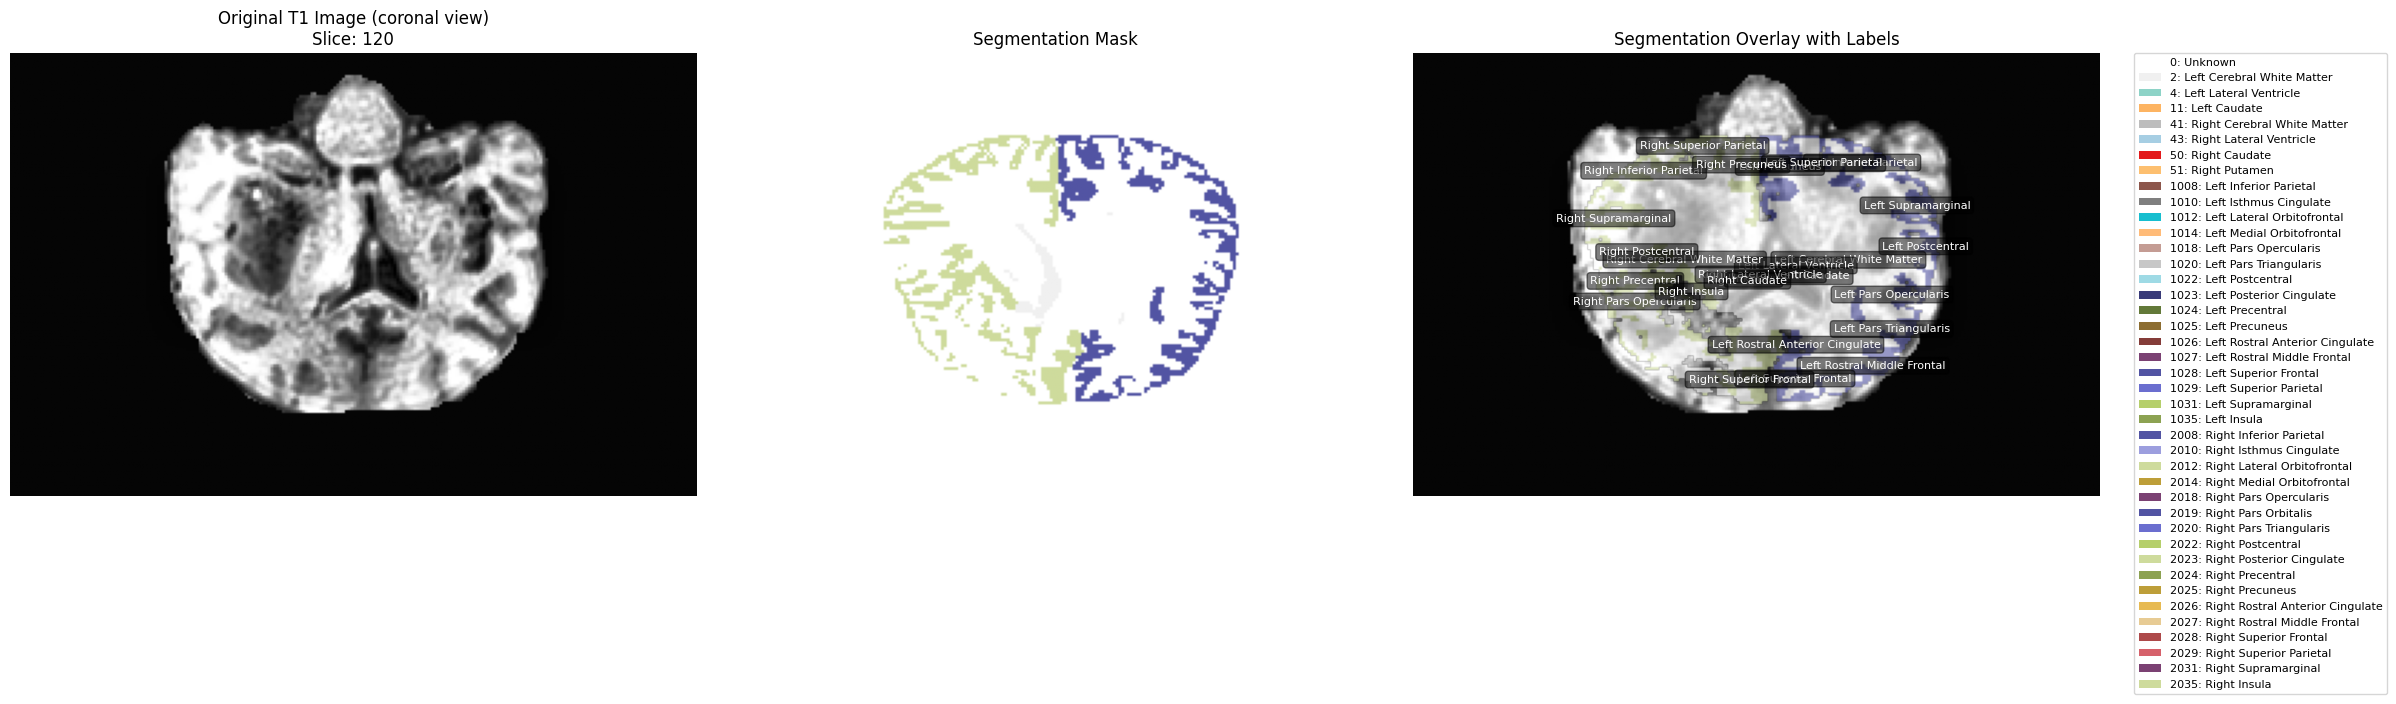


Generating sagittal view visualization...
Unique region IDs in this slice: [   0    2    7    8   15   16   24   41   43   46   47   49   50   58
   60   63   77 1005 1011 1013 1021 1025 2002 2010 2012 2014 2017 2023
 2025 2026 2028 2029]


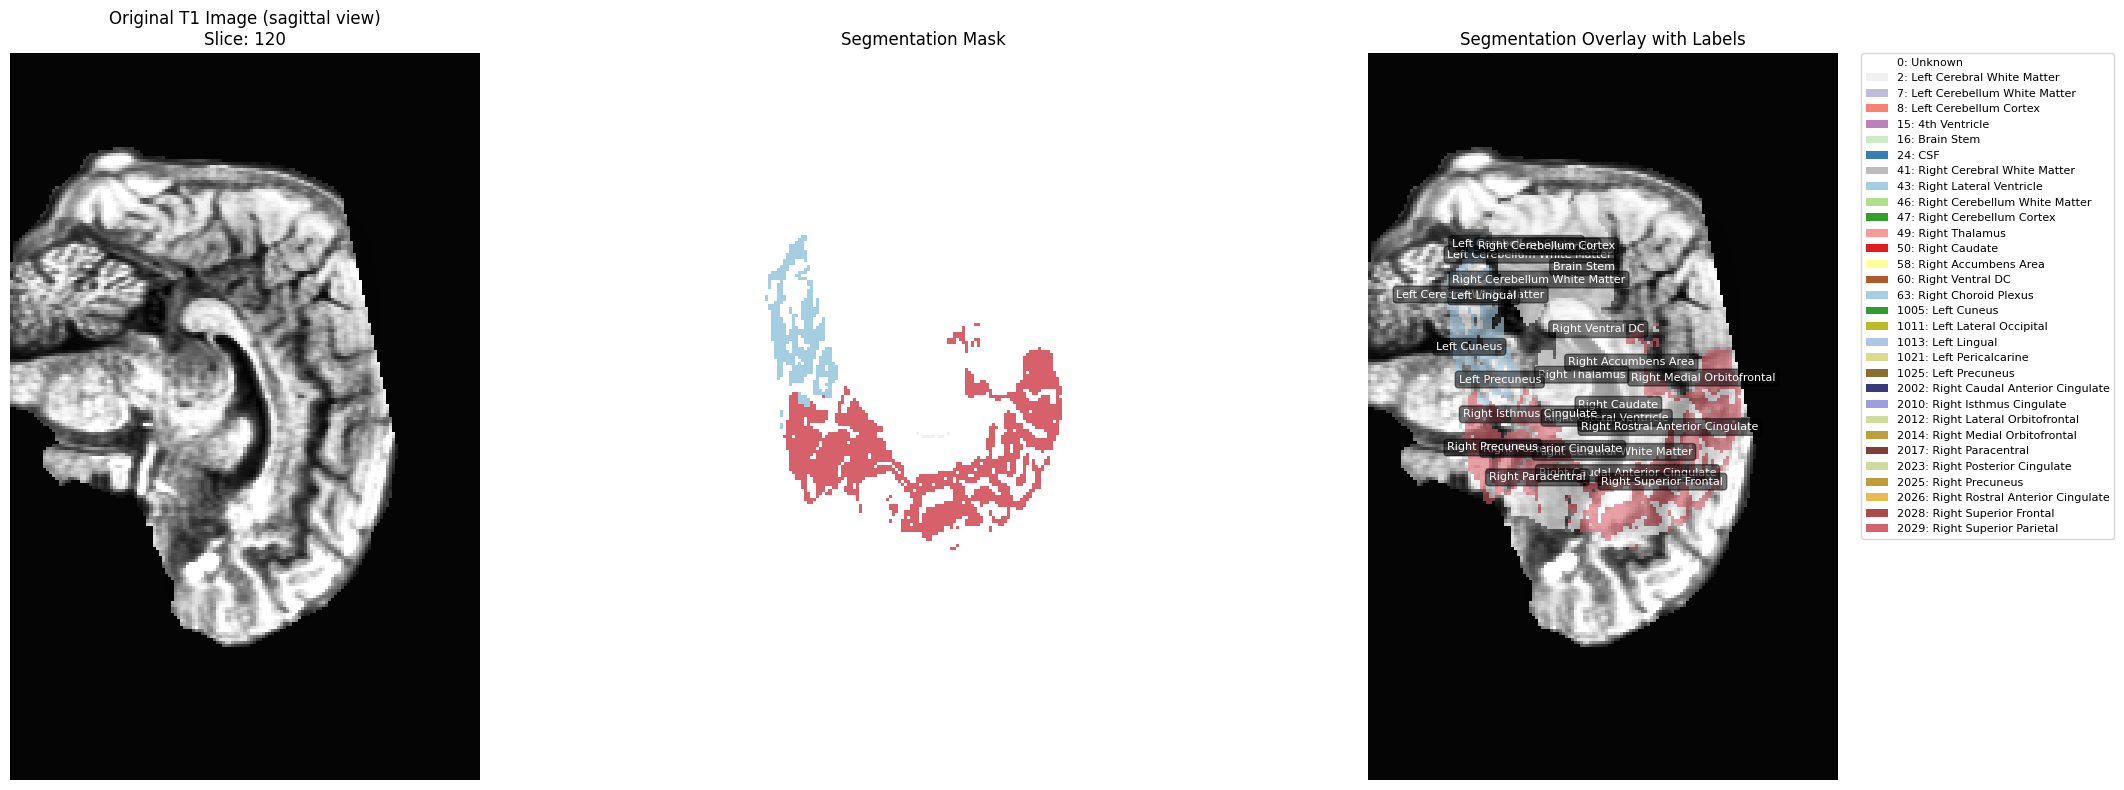


Calculating region statistics...

Brain Region Statistics:
Region Name                                   Label ID   Voxel Count     Volume (cm³)   
-------------------------------------------------------------------------------------
Unknown                                       0          8,251,351       8251.35        
Left Cerebral White Matter                    2          174,386         174.39         
Left Lateral Ventricle                        4          6,060           6.06           
Left Inferior Lateral Ventricle               5          105             0.11           
Left Cerebellum White Matter                  7          9,946           9.95           
Left Cerebellum Cortex                        8          21,904          21.90          
Left Thalamus                                 10         5,372           5.37           
Left Caudate                                  11         2,123           2.12           
Left Putamen                                  12     

In [2]:


class BrainSegmentation:
    def __init__(self, input_file):
        """
        Initialize the brain segmentation process

        :param input_file: Path to the T1-weighted MRI file (.nii or .nii.gz)
        """

        if not os.path.exists(input_file):
            raise FileNotFoundError(f"Input file not found: {input_file}")

        self.input_file = os.path.abspath(input_file)
        self.base_dir = os.path.dirname(self.input_file)
        self.seg_dir = os.path.join(self.base_dir, 'fastsurfer_seg')


        self.seg_file = None


        self.install_dependencies()


        self.setup_directories()
        self.run_fastsurfer()


        self.verify_segmentation()

    def install_dependencies(self):
        """Install all required dependencies for FastSurfer"""
        dependencies = [
            'yacs==0.1.8',
            'torch',
            'torchvision',
            'plotly',
            'scikit-image',
            'nibabel',
            'matplotlib'
        ]

        for dep in dependencies:
            try:
                self.run_pip_install(dep)
            except Exception as e:
                print(f"Warning: Could not install {dep}. Error: {e}")

    def run_pip_install(self, package):
        """
        Install a Python package using pip

        :param package: Package name (with optional version)
        """
        cmd = f'pip install {package}'
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

        if result.returncode != 0:
            print(f"Error installing {package}:")
            print(result.stderr)
            raise RuntimeError(f"Failed to install {package}")

    def setup_directories(self):
        """Set up necessary directories for segmentation"""
        os.makedirs(self.seg_dir, exist_ok=True)


        if not os.path.exists(os.path.join(self.base_dir, 'fastsurfer')):
            self.run_command(f'cd {self.base_dir} && git clone -q --branch stable https://github.com/deep-mi/fastsurfer.git')

    def run_command(self, command):
        """
        Run shell command with error handling

        :param command: Shell command to execute
        """
        try:
            result = subprocess.run(command, shell=True, check=True,
                                  stdout=subprocess.PIPE,
                                  stderr=subprocess.PIPE,
                                  text=True)
            print(result.stdout)
        except subprocess.CalledProcessError as e:
            print(f"Error executing command: {command}")
            print(f"Error output: {e.stderr}")
            raise

    def run_fastsurfer(self):
        """Run FastSurfer segmentation with comprehensive error handling"""

        fastsurfer_home = os.path.join(self.base_dir, 'fastsurfer')
        fastsurfer_script = os.path.join(fastsurfer_home, 'run_fastsurfer.sh')


        os.chmod(fastsurfer_script, 0o755)


        command = (
            f'cd {self.base_dir} && '
            f'FASTSURFER_HOME={fastsurfer_home} '
            f'{fastsurfer_script} '
            f'--t1 {self.input_file} '
            f'--sd {self.seg_dir} '
            f'--sid BrainSeg '
            f'--seg_only '
            f'--py python3 '
            f'--no_biasfield '
            f'--no_cereb '
            f'--no_hypothal '
            f'--allow_root'
        )


        try:
            result = subprocess.run(command, shell=True,
                                  capture_output=True,
                                  text=True)


            if result.returncode != 0:
                print("FastSurfer Segmentation Failed:")
                print(result.stderr)
                raise RuntimeError("Segmentation process encountered an error")

            print("Segmentation completed successfully")
        except Exception as e:
            print(f"Error running FastSurfer: {e}")
            raise

    def verify_segmentation(self):
        """
        Verify that segmentation files exist

        :raises FileNotFoundError: If segmentation files are missing
        """

        print("Files in segmentation directory:")
        for root, dirs, files in os.walk(self.seg_dir):
            for file in files:
                print(os.path.join(root, file))


        possible_paths = [
            os.path.join(self.seg_dir, 'BrainSeg', 'mri', 'aparc.DKTatlas+aseg.deep.mgz'),
            os.path.join(self.seg_dir, 'BrainSeg', 'mri', 'aseg.mgz'),
            os.path.join(self.seg_dir, 'aparc.DKTatlas+aseg.deep.mgz'),
            os.path.join(self.seg_dir, 'aseg.mgz'),
            os.path.join(self.seg_dir, 'BrainSeg', 'aparc.DKTatlas+aseg.deep.mgz'),
        ]

        seg_file = None
        for path in possible_paths:
            if os.path.exists(path):
                seg_file = path
                break

        if not seg_file:
            raise FileNotFoundError("No segmentation files found in the expected locations")

        self.orig_img = nib.load(self.input_file)
        self.orig_data = self.orig_img.get_fdata()

        seg_img = nib.load(seg_file)
        self.pred_data = np.asarray(seg_img.dataobj)

        if self.orig_data.shape != self.pred_data.shape:
            print("Warning: Original and segmentation dimensions don't match")
            print(f"Original shape: {self.orig_data.shape}")
            print(f"Segmentation shape: {self.pred_data.shape}")

            from scipy.ndimage import zoom
            zoom_factors = [o/s for o,s in zip(self.orig_data.shape, self.pred_data.shape)]
            self.pred_data = zoom(self.pred_data, zoom_factors, order=0)

        print(f"Segmentation verified successfully using file: {seg_file}")

    def get_brain_region_labels(self):
        """
        Comprehensive brain region labels with color mapping
        Includes all regions from FreeSurfer's aseg+DKTatlas

        :return: Dictionary of brain regions with their labels and colors
        """
        return {

            4: {'name': 'Left Lateral Ventricle', 'color': '#8dd3c7'},
            5: {'name': 'Left Inferior Lateral Ventricle', 'color': '#ffffb3'},
            7: {'name': 'Left Cerebellum White Matter', 'color': '#bebada'},
            8: {'name': 'Left Cerebellum Cortex', 'color': '#fb8072'},
            10: {'name': 'Left Thalamus', 'color': '#80b1d3'},
            11: {'name': 'Left Caudate', 'color': '#fdb462'},
            12: {'name': 'Left Putamen', 'color': '#b3de69'},
            13: {'name': 'Left Pallidum', 'color': '#fccde5'},
            14: {'name': '3rd Ventricle', 'color': '#d9d9d9'},
            15: {'name': '4th Ventricle', 'color': '#bc80bd'},
            16: {'name': 'Brain Stem', 'color': '#ccebc5'},
            17: {'name': 'Left Hippocampus', 'color': '#ffed6f'},
            18: {'name': 'Left Amygdala', 'color': '#e41a1c'},
            24: {'name': 'CSF', 'color': '#377eb8'},
            26: {'name': 'Left Accumbens Area', 'color': '#4daf4a'},
            28: {'name': 'Left Ventral DC', 'color': '#984ea3'},
            31: {'name': 'Left Choroid Plexus', 'color': '#ff7f00'},

            43: {'name': 'Right Lateral Ventricle', 'color': '#a6cee3'},
            44: {'name': 'Right Inferior Lateral Ventricle', 'color': '#1f78b4'},
            46: {'name': 'Right Cerebellum White Matter', 'color': '#b2df8a'},
            47: {'name': 'Right Cerebellum Cortex', 'color': '#33a02c'},
            49: {'name': 'Right Thalamus', 'color': '#fb9a99'},
            50: {'name': 'Right Caudate', 'color': '#e31a1c'},
            51: {'name': 'Right Putamen', 'color': '#fdbf6f'},
            52: {'name': 'Right Pallidum', 'color': '#ff7f00'},
            53: {'name': 'Right Hippocampus', 'color': '#cab2d6'},
            54: {'name': 'Right Amygdala', 'color': '#6a3d9a'},
            58: {'name': 'Right Accumbens Area', 'color': '#ffff99'},
            60: {'name': 'Right Ventral DC', 'color': '#b15928'},
            63: {'name': 'Right Choroid Plexus', 'color': '#a6cee3'},

            1002: {'name': 'Left Caudal Anterior Cingulate', 'color': '#1f77b4'},
            1003: {'name': 'Left Caudal Middle Frontal', 'color': '#ff7f0e'},
            1005: {'name': 'Left Cuneus', 'color': '#2ca02c'},
            1006: {'name': 'Left Entorhinal', 'color': '#d62728'},
            1007: {'name': 'Left Fusiform', 'color': '#9467bd'},
            1008: {'name': 'Left Inferior Parietal', 'color': '#8c564b'},
            1009: {'name': 'Left Inferior Temporal', 'color': '#e377c2'},
            1010: {'name': 'Left Isthmus Cingulate', 'color': '#7f7f7f'},
            1011: {'name': 'Left Lateral Occipital', 'color': '#bcbd22'},
            1012: {'name': 'Left Lateral Orbitofrontal', 'color': '#17becf'},
            1013: {'name': 'Left Lingual', 'color': '#aec7e8'},
            1014: {'name': 'Left Medial Orbitofrontal', 'color': '#ffbb78'},
            1015: {'name': 'Left Middle Temporal', 'color': '#98df8a'},
            1016: {'name': 'Left Parahippocampal', 'color': '#ff9896'},
            1017: {'name': 'Left Paracentral', 'color': '#c5b0d5'},
            1018: {'name': 'Left Pars Opercularis', 'color': '#c49c94'},
            1019: {'name': 'Left Pars Orbitalis', 'color': '#f7b6d2'},
            1020: {'name': 'Left Pars Triangularis', 'color': '#c7c7c7'},
            1021: {'name': 'Left Pericalcarine', 'color': '#dbdb8d'},
            1022: {'name': 'Left Postcentral', 'color': '#9edae5'},
            1023: {'name': 'Left Posterior Cingulate', 'color': '#393b79'},
            1024: {'name': 'Left Precentral', 'color': '#637939'},
            1025: {'name': 'Left Precuneus', 'color': '#8c6d31'},
            1026: {'name': 'Left Rostral Anterior Cingulate', 'color': '#843c39'},
            1027: {'name': 'Left Rostral Middle Frontal', 'color': '#7b4173'},
            1028: {'name': 'Left Superior Frontal', 'color': '#5254a3'},
            1029: {'name': 'Left Superior Parietal', 'color': '#6b6ecf'},
            1030: {'name': 'Left Superior Temporal', 'color': '#9c9ede'},
            1031: {'name': 'Left Supramarginal', 'color': '#b5cf6b'},
            1034: {'name': 'Left Transverse Temporal', 'color': '#cedb9c'},
            1035: {'name': 'Left Insula', 'color': '#8ca252'},

            2002: {'name': 'Right Caudal Anterior Cingulate', 'color': '#393b79'},
            2003: {'name': 'Right Caudal Middle Frontal', 'color': '#637939'},
            2005: {'name': 'Right Cuneus', 'color': '#8c6d31'},
            2006: {'name': 'Right Entorhinal', 'color': '#843c39'},
            2007: {'name': 'Right Fusiform', 'color': '#7b4173'},
            2008: {'name': 'Right Inferior Parietal', 'color': '#5254a3'},
            2009: {'name': 'Right Inferior Temporal', 'color': '#6b6ecf'},
            2010: {'name': 'Right Isthmus Cingulate', 'color': '#9c9ede'},
            2011: {'name': 'Right Lateral Occipital', 'color': '#b5cf6b'},
            2012: {'name': 'Right Lateral Orbitofrontal', 'color': '#cedb9c'},
            2013: {'name': 'Right Lingual', 'color': '#8ca252'},
            2014: {'name': 'Right Medial Orbitofrontal', 'color': '#bd9e39'},
            2015: {'name': 'Right Middle Temporal', 'color': '#e7ba52'},
            2016: {'name': 'Right Parahippocampal', 'color': '#e7cb94'},
            2017: {'name': 'Right Paracentral', 'color': '#843c39'},
            2018: {'name': 'Right Pars Opercularis', 'color': '#7b4173'},
            2019: {'name': 'Right Pars Orbitalis', 'color': '#5254a3'},
            2020: {'name': 'Right Pars Triangularis', 'color': '#6b6ecf'},
            2021: {'name': 'Right Pericalcarine', 'color': '#9c9ede'},
            2022: {'name': 'Right Postcentral', 'color': '#b5cf6b'},
            2023: {'name': 'Right Posterior Cingulate', 'color': '#cedb9c'},
            2024: {'name': 'Right Precentral', 'color': '#8ca252'},
            2025: {'name': 'Right Precuneus', 'color': '#bd9e39'},
            2026: {'name': 'Right Rostral Anterior Cingulate', 'color': '#e7ba52'},
            2027: {'name': 'Right Rostral Middle Frontal', 'color': '#e7cb94'},
            2028: {'name': 'Right Superior Frontal', 'color': '#ad494a'},
            2029: {'name': 'Right Superior Parietal', 'color': '#d6616b'},
            2030: {'name': 'Right Superior Temporal', 'color': '#e7969c'},
            2031: {'name': 'Right Supramarginal', 'color': '#7b4173'},
            2034: {'name': 'Right Transverse Temporal', 'color': '#de9ed6'},
            2035: {'name': 'Right Insula', 'color': '#cedb9c'},

            0: {'name': 'Unknown', 'color': '#ffffff'},
            2: {'name': 'Left Cerebral White Matter', 'color': '#f0f0f0'},
            3: {'name': 'Left Cerebral Cortex', 'color': '#d9d9d9'},
            41: {'name': 'Right Cerebral White Matter', 'color': '#bdbdbd'},
            42: {'name': 'Right Cerebral Cortex', 'color': '#969696'}
        }

    def get_slice_data(self, axis, slice_num):
        """
        Get properly oriented slice data for visualization

        :param axis: Which plane to display ('axial', 'coronal', 'sagittal')
        :param slice_num: Slice number to extract
        :return: Tuple of (original_slice, segmentation_slice)
        """
        if axis == 'axial':
            orig_slice = self.orig_data[:, :, slice_num]
            seg_slice = self.pred_data[:, :, slice_num]

            orig_slice = np.rot90(orig_slice, k=1)
            seg_slice = np.rot90(seg_slice, k=1)
        elif axis == 'coronal':
            orig_slice = self.orig_data[:, slice_num, :]
            seg_slice = self.pred_data[:, slice_num, :]

            orig_slice = np.rot90(orig_slice, k=1)
            seg_slice = np.rot90(seg_slice, k=1)
        else:  # sagittal
            orig_slice = self.orig_data[slice_num, :, :]
            seg_slice = self.pred_data[slice_num, :, :]


        return orig_slice, seg_slice

    def enhance_image_contrast(self, image):
        """Enhance image contrast using histogram equalization"""

        p2, p98 = np.percentile(image, (2, 98))
        image = exposure.rescale_intensity(image, in_range=(p2, p98))

        image = exposure.equalize_adapthist(image, clip_limit=0.03)
        return image

    def plot_segmentation_2d(self, slice_num=None, axis='axial'):
        """
        Plot 2D segmentation overlay with consistent orientation

        :param slice_num: Specific slice to display (default: middle slice)
        :param axis: Which plane to display ('axial', 'coronal', 'sagittal')
        """
        if slice_num is None:
            if axis == 'axial':
                slice_num = self.orig_data.shape[2] // 2
            elif axis == 'coronal':
                slice_num = self.orig_data.shape[1] // 2
            else:  # sagittal
                slice_num = self.orig_data.shape[0] // 2

        region_labels = self.get_brain_region_labels()

        orig_slice, seg_slice = self.get_slice_data(axis, slice_num)

        orig_slice_enhanced = self.enhance_image_contrast(orig_slice)

        plt.figure(figsize=(24, 8))

        plt.subplot(131)
        plt.imshow(orig_slice_enhanced, cmap='gray', origin='lower')
        plt.title(f'Original T1 Image ({axis} view)\nSlice: {slice_num}', fontsize=12)
        plt.axis('off')

        plt.subplot(132)

        unique_labels = np.unique(seg_slice)
        print(f"Unique region IDs in this slice: {unique_labels}")

        present_regions = []
        cmap_colors = []
        label_list = []

        for label in unique_labels:
            if label in region_labels:
                present_regions.append(label)
                cmap_colors.append(plt.cm.colors.to_rgb(region_labels[label]['color']))
                label_list.append(f"{label}: {region_labels[label]['name']}")
            else:
                print(f"Warning: Label {label} not found in region dictionary")

        if 0 not in present_regions:
            present_regions.insert(0, 0)
            cmap_colors.insert(0, plt.cm.colors.to_rgb(region_labels[0]['color']))
            label_list.insert(0, "0: Unknown")

        cmap = ListedColormap(cmap_colors)

        plt.imshow(seg_slice, cmap=cmap, origin='lower',
                  vmin=min(present_regions), vmax=max(present_regions))
        plt.title('Segmentation Mask', fontsize=12)
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(orig_slice_enhanced, cmap='gray', origin='lower')

        masked_seg = np.ma.masked_where(seg_slice == 0, seg_slice)
        seg_plot = plt.imshow(masked_seg, cmap=cmap, alpha=0.6, origin='lower',
                             vmin=min(present_regions), vmax=max(present_regions))

        self.label_major_regions(seg_slice, region_labels)

        plt.title('Segmentation Overlay with Labels', fontsize=12)
        plt.axis('off')

        legend_elements = [Patch(facecolor=cmap_colors[i],
                               label=label_list[i])
                          for i in range(len(present_regions))]

        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1),
                  loc='upper left', borderaxespad=0., fontsize=8)

        plt.tight_layout()
        plt.show()

    def label_major_regions(self, seg_slice, region_labels):
        """Add text labels for major brain regions"""
        from scipy.ndimage import center_of_mass

        min_region_size = 50

        unique_labels, counts = np.unique(seg_slice, return_counts=True)

        for label, count in zip(unique_labels, counts):
            if label in region_labels and count > min_region_size:

                mask = (seg_slice == label)
                if np.any(mask):
                    y, x = center_of_mass(mask)
                    plt.text(x, y, region_labels[label]['name'],
                            color='white', fontsize=8,
                            ha='center', va='center',
                            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

    def print_region_statistics(self):
        """
        Print statistics for identified brain regions
        """
        region_labels = self.get_brain_region_labels()

        print("\nBrain Region Statistics:")
        print("{:<45} {:<10} {:<15} {:<15}".format("Region Name", "Label ID", "Voxel Count", "Volume (cm³)"))
        print("-" * 85)


        unique_labels, counts = np.unique(self.pred_data, return_counts=True)


        voxel_volume_mm3 = np.prod(self.orig_img.header.get_zooms())
        voxel_volume_cm3 = voxel_volume_mm3 / 1000

        for label, count in zip(unique_labels, counts):
            if label in region_labels:
                region_volume_cm3 = count * voxel_volume_cm3
                print("{:<45} {:<10} {:<15,} {:<15.2f}".format(
                    region_labels[label]['name'],
                    label,
                    count,
                    region_volume_cm3))
            else:
                print(f"Warning: Found unlabeled region with ID {label}")

def main():

    input_file = input("Enter the path to your T1-weighted MRI file: ").strip()

    try:

        print("\nInitializing brain segmentation...")
        seg = BrainSegmentation(input_file)


        print("\nGenerating axial view visualization...")
        seg.plot_segmentation_2d(axis='axial')

        print("\nGenerating coronal view visualization...")
        seg.plot_segmentation_2d(axis='coronal')

        print("\nGenerating sagittal view visualization...")
        seg.plot_segmentation_2d(axis='sagittal')


        print("\nCalculating region statistics...")
        seg.print_region_statistics()

    except Exception as e:
        print(f"\nAn error occurred during segmentation: {str(e)}")
        print("\nPossible solutions:")
        print("1. Check that the input file is a valid T1-weighted MRI in .nii or .nii.gz format")
        print("2. Ensure you have sufficient disk space (minimum 10GB free)")
        print("3. Verify that all dependencies are correctly installed")
        print("4. Check that FastSurfer cloned correctly (try deleting the fastsurfer directory and rerunning)")
        print("5. Make sure your system meets the requirements (GPU recommended)")
        print("6. Check file permissions and directory access rights")
        print("7. Try running with a smaller input file if memory is an issue")

if __name__ == '__main__':

    warnings.filterwarnings("ignore", category=UserWarning, module="nibabel")
    main()